In [741]:
import pandas as pd
import numpy as np
import unicodedata
df_RedVial = pd.read_csv("1_Red_vial_nacional_2022-jul2024_0.csv", encoding='utf-8')
print("Primeras filas:")
print(df_RedVial.head())

df_RedVial.columns = df_RedVial.columns.str.strip().str.upper().str.replace(" ", "_")

print("Primeras filas:")
print(df_RedVial.head())

Primeras filas:
   ID_RVN  ID_DEPARTAMENTO DEPARTAMENTO CODIGO_RUTA  \
0       1               20        PIURA       PE-02   
1       2               20        PIURA       PE-02   
2       3               20        PIURA       PE-02   
3       4               20        PIURA      PE-02A   
4       5               20        PIURA      PE-02A   

                                         TRAYECTORIA  INICIO   FINAL  \
0                     Emp. PE-1N (Dv. Paita) - Paita   0.000   7.918   
1                     Emp. PE-1N (Dv. Paita) - Paita   7.918  40.095   
2                     Emp. PE-1N (Dv. Paita) - Paita  40.095  49.058   
3  Emp. PE-1N J (Dv. Huancabamba) - Buenos Aires ...   0.000  19.720   
4  Emp. PE-1N J (Dv. Huancabamba) - Buenos Aires ...  19.720  27.345   

  CLASIFICACION_EJE JERARQUIA  LONGITUD  NRO_CARRILES  SUPERFICIE  \
0       Transversal        RN     7.918             2           1   
1       Transversal        RN    32.177             2           1   
2       Trans

In [742]:
df_RedVial = df_RedVial[[
    "CODIGO_RUTA", "INICIO", "FINAL", "LONGITUD", "NRO_CARRILES",
    "SUPERFICIE_L", "DEPARTAMENTO", "JERARQUIA"
]]
df_RedVial = df_RedVial.rename(columns={
    "CODIGO_RUTA": "CODRUTA",
    "NRO_CARRILES": "NROCARRIL"
})
print("Primeras filas:")
print(df_RedVial.head())

Primeras filas:
  CODRUTA  INICIO   FINAL  LONGITUD  NROCARRIL SUPERFICIE_L DEPARTAMENTO  \
0   PE-02   0.000   7.918     7.918          2  Pavimentado        PIURA   
1   PE-02   7.918  40.095    32.177          2  Pavimentado        PIURA   
2   PE-02  40.095  49.058     8.963          2  Pavimentado        PIURA   
3  PE-02A   0.000  19.720    19.720          2  Pavimentado        PIURA   
4  PE-02A  19.720  27.345     7.625          2  Pavimentado        PIURA   

  JERARQUIA  
0        RN  
1        RN  
2        RN  
3        RN  
4        RN  


In [743]:
print(" Tipos de datos originales:")
print(df_RedVial.dtypes)
total_original = len(df_RedVial)
print(f"\n Total de registros originales: {total_original}")

 Tipos de datos originales:
CODRUTA          object
INICIO          float64
FINAL           float64
LONGITUD        float64
NROCARRIL         int64
SUPERFICIE_L     object
DEPARTAMENTO     object
JERARQUIA        object
dtype: object

 Total de registros originales: 20255


In [744]:
eliminados_carril = (df_RedVial["NROCARRIL"] == -1).sum()
print(f" Registros con NROCARRIL = -1 eliminados: {eliminados_carril}")
df_RedVial = df_RedVial[df_RedVial["NROCARRIL"] != -1]


 Registros con NROCARRIL = -1 eliminados: 3244


In [745]:
# Normalizar texto en columnas clave
for col in ["SUPERFICIE_L", "DEPARTAMENTO", "JERARQUIA"]:
    df_RedVial[col] = df_RedVial[col].astype(str).str.strip().str.upper()

# Filtrar solo jerarquía RN y hacer copia explícita
df_rn = df_RedVial[df_RedVial["JERARQUIA"] == "RN"].copy()
print(f"Registros con JERARQUIA = 'RN': {len(df_rn)} (de {len(df_RedVial)})")

# Eliminar duplicados
df_rn = df_rn.drop_duplicates()



Registros con JERARQUIA = 'RN': 17011 (de 17011)


In [746]:
nulos= df_RedVial.isnull().sum()
porcentaje = (nulos / len(df_RedVial)) * 100

reporte = pd.DataFrame({
    "NULOS": nulos,
    "PORCENTAJE (%)": porcentaje.round(2)
})

print(reporte)

              NULOS  PORCENTAJE (%)
CODRUTA           0             0.0
INICIO            0             0.0
FINAL             0             0.0
LONGITUD          0             0.0
NROCARRIL         0             0.0
SUPERFICIE_L      0             0.0
DEPARTAMENTO      0             0.0
JERARQUIA         0             0.0


In [747]:
print(df_RedVial)

      CODRUTA  INICIO   FINAL  LONGITUD  NROCARRIL SUPERFICIE_L DEPARTAMENTO  \
0       PE-02   0.000   7.918     7.918          2  PAVIMENTADO        PIURA   
1       PE-02   7.918  40.095    32.177          2  PAVIMENTADO        PIURA   
2       PE-02  40.095  49.058     8.963          2  PAVIMENTADO        PIURA   
3      PE-02A   0.000  19.720    19.720          2  PAVIMENTADO        PIURA   
4      PE-02A  19.720  27.345     7.625          2  PAVIMENTADO        PIURA   
...       ...     ...     ...       ...        ...          ...          ...   
20244  PE-5SA  16.853  22.023     5.170          2     AFIRMADO        JUNIN   
20245  PE-5SA  16.337  16.853     0.516          2     AFIRMADO        JUNIN   
20246  PE-5SA   3.575  16.337    12.762          2     AFIRMADO        JUNIN   
20247  PE-5SA   0.000   3.305     3.305          2     AFIRMADO        JUNIN   
20248  PE-5SA   3.305   3.575     0.270          2     AFIRMADO        JUNIN   

      JERARQUIA  
0            RN  
1  

In [748]:
df_RedVial = df_RedVial.sort_values(by=["CODRUTA", "INICIO"])

# Detectar cambio de CODRUTA o en las columnas clave
cols_clave = ["CODRUTA", "NROCARRIL", "SUPERFICIE_L"]
df_RedVial["grupo_cambio"] = (df_RedVial[cols_clave] != df_RedVial[cols_clave].shift()).any(axis=1).cumsum()

# Agrupar manteniendo segmentos homogéneos
df_RedVial = df_RedVial.groupby("grupo_cambio").agg({
    "CODRUTA": "first",
    "INICIO": "first",
    "FINAL": "last",
    "LONGITUD": "sum",
    "NROCARRIL": "first",
    "SUPERFICIE_L": "first",
    "DEPARTAMENTO": "first",
    "JERARQUIA": "first"
}).reset_index(drop=True)

In [749]:
print(df_RedVial)

     CODRUTA   INICIO    FINAL  LONGITUD  NROCARRIL         SUPERFICIE_L  \
0      PE-02    0.000   49.058   147.174          2          PAVIMENTADO   
1     PE-02A    0.000   77.720   233.160          2          PAVIMENTADO   
2     PE-02A   77.720   77.818     0.294          1          PAVIMENTADO   
3     PE-02A   77.818  104.070    78.756          1  ASFALTADO ECONÓMICO   
4     PE-02A  104.070  143.469   118.197          2  ASFALTADO ECONÓMICO   
...      ...      ...      ...       ...        ...                  ...   
1100   PE-5S   59.657  109.102   148.335          2          PAVIMENTADO   
1101   PE-5S  109.102  110.102     3.000          2  ASFALTADO ECONÓMICO   
1102   PE-5S  110.102  174.922   194.460          2          PAVIMENTADO   
1103   PE-5S  174.922  194.489    58.590          2             AFIRMADO   
1104  PE-5SA    0.000   24.164    72.208          2             AFIRMADO   

     DEPARTAMENTO JERARQUIA  
0           PIURA        RN  
1           PIURA        RN

In [750]:
df_RedVial.to_csv("df_RedVial.csv", index=False, encoding='utf-8')

In [751]:
df_ONSV = pd.read_excel("BBDD ONSV - SINIESTROS 2021-2023.xlsx", skiprows=3)

# Mostrar columnas disponibles
print("Columnas encontradas:")
print(df_ONSV.columns.tolist())


Columnas encontradas:
['CÓDIGO SINIESTRO', 'FECHA SINIESTRO', 'HORA SINIESTRO', 'CLASE SINIESTRO', 'CANTIDAD DE FALLECIDOS', 'CANTIDAD DE LESIONADOS', 'CANTIDAD DE VEHICULOS DAÑADOS', 'DEPARTAMENTO', 'PROVINCIA', 'DISTRITO', 'ZONA', 'TIPO DE VÍA', 'RED VIAL', 'COD CARRETERA', 'EXISTE CICLOVÍA', 'COORDENADAS LATITUD', 'COORDENADAS  LONGITUD', 'CONDICIÓN CLIMÁTICA', 'ZONIFICACIÓN', 'CARACTERÍSTICAS DE VÍA', 'PERFIL LONGITUDINAL VÍA', 'SUPERFICIE DE CALZADA', '¿EXISTE SEÑAL VERTICAL?', 'CLASIFICACIÓN DE LA SEÑAL VERTICAL Nº 1', 'CLASIFICACIÓN DE LA SEÑAL VERTICAL Nº 2', '¿EXISTE SEÑAL HORIZONTAL?', 'CAUSA FACTOR PRINCIPAL', 'CAUSA ESPECÍFICA']


In [752]:
df_ONSV = df_ONSV[[
    "FECHA SINIESTRO",
    "HORA SINIESTRO",
    "CANTIDAD DE FALLECIDOS",
    "CANTIDAD DE LESIONADOS",
    "DEPARTAMENTO",
    "PROVINCIA",
    "DISTRITO",
    "COD CARRETERA",
    "COORDENADAS LATITUD",
    "COORDENADAS  LONGITUD",
    "TIPO DE VÍA",
    "SUPERFICIE DE CALZADA",
    "CONDICIÓN CLIMÁTICA",
    "RED VIAL",
    "ZONA",
    "¿EXISTE SEÑAL VERTICAL?",
    "¿EXISTE SEÑAL HORIZONTAL?",
    "CAUSA FACTOR PRINCIPAL",
    "CAUSA ESPECÍFICA",
    "CLASE SINIESTRO"
]]

df_ONSV.columns = df_ONSV.columns.str.strip().str.upper().str.replace(" ", "_")

In [753]:
# Eliminar filas sin coordenadas (opcional, para mapas)
coordenadas_incompletas = df_ONSV["COORDENADAS_LATITUD"].isna() | df_ONSV["COORDENADAS__LONGITUD"].isna()
print(f" Registros eliminados por falta de coordenadas: {coordenadas_incompletas.sum()}")
df_ONSV = df_ONSV[~coordenadas_incompletas]

 Registros eliminados por falta de coordenadas: 0


In [754]:
def normalizar_texto(texto):
    if not isinstance(texto, str):
        return texto
    texto = unicodedata.normalize('NFKD', texto).encode('ascii', 'ignore').decode('utf-8')
    return texto.strip().upper()

In [755]:
columnas_texto = [
    "DEPARTAMENTO", "PROVINCIA", "DISTRITO", "TIPO_DE_VÍA", "SUPERFICIE_DE_CALZADA",
    "CONDICIÓN_CLIMÁTICA", "ZONA", "¿EXISTE_SEÑAL_VERTICAL?", "¿EXISTE_SEÑAL_HORIZONTAL?",
    "CAUSA_FACTOR_PRINCIPAL", "CAUSA_ESPECÍFICA","CLASE_SINIESTRO","RED_VIAL"
]

In [756]:
for col in columnas_texto:
    df_ONSV[col] = df_ONSV[col].apply(normalizar_texto)

print("Primeras filas:")
print(df_ONSV)

Primeras filas:
     FECHA_SINIESTRO HORA_SINIESTRO  CANTIDAD_DE_FALLECIDOS  \
0         01/01/2021          04:40                       1   
1         01/01/2021          05:45                       1   
2         01/01/2021          06:00                       2   
3         01/01/2021          07:00                       1   
4         01/01/2021          14:00                       1   
...              ...            ...                     ...   
6716      31/12/2023          11:57                       1   
6717      31/12/2023          17:00                       1   
6718      31/12/2023          18:50                       1   
6719      31/12/2023          19:15                       1   
6720      31/12/2023          21:25                       1   

      CANTIDAD_DE_LESIONADOS DEPARTAMENTO  PROVINCIA                 DISTRITO  \
0                          0         LIMA     HUARAL                   HUARAL   
1                          3         LIMA       LIMA             

In [757]:
# Convertir valores de 'COD_CARRETERA' en nulos
df_ONSV["COD_CARRETERA"] = df_ONSV["COD_CARRETERA"].replace(
    ["NO CORRESPONDE", "SIN CLASIFICAR"],
    np.nan
)

# Convertir valores de 'CAUSA_FACTOR_PRINCIPAL' en nulos
df_ONSV["CAUSA_FACTOR_PRINCIPAL"] = df_ONSV["CAUSA_FACTOR_PRINCIPAL"].replace(
    ["NO IDENTIFICA LA CAUSA"],
    np.nan
)

In [758]:
# Reporte inicial de nulos y porcentaje
nulos= df_ONSV.isnull().sum()
porcentaje_antes = (nulos / len(df_ONSV)) * 100

reporte_antes = pd.DataFrame({
    "NULOS": nulos,
    "PORCENTAJE (%)": porcentaje_antes.round(2)
})

print("NULOS ANTES DE LIMPIAR:\n")
print(reporte_antes)

NULOS ANTES DE LIMPIAR:

                           NULOS  PORCENTAJE (%)
FECHA_SINIESTRO                0            0.00
HORA_SINIESTRO                 0            0.00
CANTIDAD_DE_FALLECIDOS         0            0.00
CANTIDAD_DE_LESIONADOS         0            0.00
DEPARTAMENTO                   0            0.00
PROVINCIA                      0            0.00
DISTRITO                       0            0.00
COD_CARRETERA               1687           25.10
COORDENADAS_LATITUD            0            0.00
COORDENADAS__LONGITUD          0            0.00
TIPO_DE_VÍA                    0            0.00
SUPERFICIE_DE_CALZADA        313            4.66
CONDICIÓN_CLIMÁTICA          313            4.66
RED_VIAL                       0            0.00
ZONA                          22            0.33
¿EXISTE_SEÑAL_VERTICAL?     5191           77.24
¿EXISTE_SEÑAL_HORIZONTAL?   5191           77.24
CAUSA_FACTOR_PRINCIPAL      3152           46.90
CAUSA_ESPECÍFICA            3218           4

In [759]:
df_ONSV = df_ONSV.drop(columns=['¿EXISTE_SEÑAL_VERTICAL?', '¿EXISTE_SEÑAL_HORIZONTAL?'])

In [760]:
df_ONSV = df_ONSV.drop(columns=['CAUSA_FACTOR_PRINCIPAL', 'CAUSA_ESPECÍFICA'])

In [761]:
# Reporte final de nulos y porcentaje
nulos= df_ONSV.isnull().sum()
porcentaje = (nulos / len(df_ONSV)) * 100

reporte_despues = pd.DataFrame({
    "NULOS": nulos,
    "PORCENTAJE (%)": porcentaje.round(2)
})

print("NULOS DESPUES DE LIMPIAR:\n")
print(reporte_despues)

NULOS DESPUES DE LIMPIAR:

                        NULOS  PORCENTAJE (%)
FECHA_SINIESTRO             0            0.00
HORA_SINIESTRO              0            0.00
CANTIDAD_DE_FALLECIDOS      0            0.00
CANTIDAD_DE_LESIONADOS      0            0.00
DEPARTAMENTO                0            0.00
PROVINCIA                   0            0.00
DISTRITO                    0            0.00
COD_CARRETERA            1687           25.10
COORDENADAS_LATITUD         0            0.00
COORDENADAS__LONGITUD       0            0.00
TIPO_DE_VÍA                 0            0.00
SUPERFICIE_DE_CALZADA     313            4.66
CONDICIÓN_CLIMÁTICA       313            4.66
RED_VIAL                    0            0.00
ZONA                       22            0.33
CLASE_SINIESTRO             0            0.00


In [762]:
print(df_ONSV.head())

  FECHA_SINIESTRO HORA_SINIESTRO  CANTIDAD_DE_FALLECIDOS  \
0      01/01/2021          04:40                       1   
1      01/01/2021          05:45                       1   
2      01/01/2021          06:00                       2   
3      01/01/2021          07:00                       1   
4      01/01/2021          14:00                       1   

   CANTIDAD_DE_LESIONADOS DEPARTAMENTO PROVINCIA                 DISTRITO  \
0                       0         LIMA    HUARAL                   HUARAL   
1                       3         LIMA      LIMA               PACHACAMAC   
2                       0  LA LIBERTAD      VIRU                     VIRU   
3                       0  LA LIBERTAD      VIRU                     VIRU   
4                       1         LIMA      LIMA  VILLA MARIA DEL TRIUNFO   

  COD_CARRETERA  COORDENADAS_LATITUD  COORDENADAS__LONGITUD TIPO_DE_VÍA  \
0        LM-671           -11.482879             -77.255547   CARRETERA   
1           NaN           

In [763]:
df_sutran  = pd.read_csv(
    "Accidentes de transito en carreteras-2020-2021-Sutran.csv",
    sep=";",
    encoding="latin1"
)
print("Columnas:")
print(df_sutran .columns.tolist())
print(df_sutran)

Columnas:
['FECHA_CORTE', 'FECHA', 'HORA', 'DEPARTAMENTO', 'CODIGO_VÍA', 'KILOMETRO', 'MODALIDAD', 'FALLECIDOS', 'HERIDOS']
      FECHA_CORTE     FECHA   HORA   DEPARTAMENTO CODIGO_VÍA KILOMETRO  \
0        20211222  20200101  05:40           LIMA      PE-1S        24   
1        20211222  20200101  16:30      CAJAMARCA      PE-3N        74   
2        20211222  20200101  07:45          PASCO      PE-3N       103   
3        20211222  20200101  18:30      CAJAMARCA      PE-08       111   
4        20211222  20200101  18:40           LIMA      PE-1N       174   
...           ...       ...    ...            ...        ...       ...   
8150     20211222  20210930  01:30         ANCASH      PE-1N       348   
8151     20211222  20210930  04:00  MADRE DE DIOS     PE-30C       417   
8152     20211222  20210930  15:10    LA LIBERTAD      PE-1N       627   
8153     20211222  20210930  02:50     LAMBAYEQUE      PE-1N       758   
8154     20211222  20210930  18:47           PUNO      PE-3S  

In [764]:
# 1. Eliminar columna que no se necesita
df_sutran  = df_sutran .drop(columns=["FECHA_CORTE"], errors="ignore")

# 2. Renombrar columnas para consistencia
df_sutran  = df_sutran .rename(columns={
    "CODIGO_VÍA": "CODIGO_VIA",
    "FALLECIDOS": "NUM_FALLECIDOS",
    "HERIDOS": "NUM_HERIDOS"
})

# 3. Reemplazar valores "N.I." o vacíos por NaN
df_sutran  = df_sutran .replace(["N.I.", "N.I", "NI", "", " ", None], np.nan)

In [765]:
# Asegurar que FECHA es string
df_sutran ["FECHA"] = df_sutran ["FECHA"].astype(str)

# Convertir a datetime y luego al formato deseado
df_sutran ["FECHA"] = pd.to_datetime(df_sutran ["FECHA"], format="%Y%m%d", errors="coerce")
df_sutran ["FECHA"] = df_sutran ["FECHA"].dt.strftime("%d/%m/%Y")

In [766]:
df_sutran ["NUM_FALLECIDOS"] = pd.to_numeric(df_sutran ["NUM_FALLECIDOS"], errors="coerce")
df_sutran ["NUM_HERIDOS"] = pd.to_numeric(df_sutran ["NUM_HERIDOS"], errors="coerce")
df_sutran ["KILOMETRO"] = pd.to_numeric(df_sutran ["KILOMETRO"], errors="coerce")
print("Primeras filas:")
print(df_sutran .head())

Primeras filas:
        FECHA   HORA DEPARTAMENTO CODIGO_VIA  KILOMETRO MODALIDAD  \
0  01/01/2020  05:40         LIMA      PE-1S       24.0  DESPISTE   
1  01/01/2020  16:30    CAJAMARCA      PE-3N       74.0  DESPISTE   
2  01/01/2020  07:45        PASCO      PE-3N      103.0  DESPISTE   
3  01/01/2020  18:30    CAJAMARCA      PE-08      111.0  DESPISTE   
4  01/01/2020  18:40         LIMA      PE-1N      174.0  DESPISTE   

   NUM_FALLECIDOS  NUM_HERIDOS  
0             0.0          0.0  
1             0.0          0.0  
2             0.0          1.0  
3             0.0          2.0  
4             0.0          5.0  


In [767]:
def normalizar_texto(txt):
    if isinstance(txt, str):
        txt = txt.strip().upper()
        return unicodedata.normalize("NFKD", txt).encode("ascii", "ignore").decode("utf-8")
    return txt

df_sutran ["DEPARTAMENTO"] = df_sutran ["DEPARTAMENTO"].apply(normalizar_texto)
df_sutran ["MODALIDAD"] = df_sutran ["MODALIDAD"].apply(normalizar_texto)
df_sutran ["CODIGO_VIA"] = df_sutran ["CODIGO_VIA"].astype(str).str.strip().str.upper()

In [768]:
print("Nulos por columna:")
print(df_sutran .isnull().sum())

Nulos por columna:
FECHA              0
HORA              88
DEPARTAMENTO       7
CODIGO_VIA         0
KILOMETRO         45
MODALIDAD         28
NUM_FALLECIDOS     3
NUM_HERIDOS       10
dtype: int64


In [769]:
print("\nPrimeras filas del Dataset 3 limpio:")
print(df_sutran)


Primeras filas del Dataset 3 limpio:
           FECHA   HORA   DEPARTAMENTO CODIGO_VIA  KILOMETRO MODALIDAD  \
0     01/01/2020  05:40           LIMA      PE-1S       24.0  DESPISTE   
1     01/01/2020  16:30      CAJAMARCA      PE-3N       74.0  DESPISTE   
2     01/01/2020  07:45          PASCO      PE-3N      103.0  DESPISTE   
3     01/01/2020  18:30      CAJAMARCA      PE-08      111.0  DESPISTE   
4     01/01/2020  18:40           LIMA      PE-1N      174.0  DESPISTE   
...          ...    ...            ...        ...        ...       ...   
8150  30/09/2021  01:30         ANCASH      PE-1N      348.0    CHOQUE   
8151  30/09/2021  04:00  MADRE DE DIOS     PE-30C      417.0    CHOQUE   
8152  30/09/2021  15:10    LA LIBERTAD      PE-1N      627.0    CHOQUE   
8153  30/09/2021  02:50     LAMBAYEQUE      PE-1N      758.0  DESPISTE   
8154  30/09/2021  18:47           PUNO      PE-3S     1296.0    CHOQUE   

      NUM_FALLECIDOS  NUM_HERIDOS  
0                0.0          0.0  
1

Integración

In [770]:
print("Columnals df_RedVial",df_RedVial.columns.tolist())


Columnals df_RedVial ['CODRUTA', 'INICIO', 'FINAL', 'LONGITUD', 'NROCARRIL', 'SUPERFICIE_L', 'DEPARTAMENTO', 'JERARQUIA']


In [771]:
print("Columnals df_ONSV",df_ONSV.columns.tolist())


Columnals df_ONSV ['FECHA_SINIESTRO', 'HORA_SINIESTRO', 'CANTIDAD_DE_FALLECIDOS', 'CANTIDAD_DE_LESIONADOS', 'DEPARTAMENTO', 'PROVINCIA', 'DISTRITO', 'COD_CARRETERA', 'COORDENADAS_LATITUD', 'COORDENADAS__LONGITUD', 'TIPO_DE_VÍA', 'SUPERFICIE_DE_CALZADA', 'CONDICIÓN_CLIMÁTICA', 'RED_VIAL', 'ZONA', 'CLASE_SINIESTRO']


In [772]:
print("Columnals df_sutran",df_sutran.columns.tolist())


Columnals df_sutran ['FECHA', 'HORA', 'DEPARTAMENTO', 'CODIGO_VIA', 'KILOMETRO', 'MODALIDAD', 'NUM_FALLECIDOS', 'NUM_HERIDOS']


In [773]:
# Red Vial
df_RedVial = df_RedVial.rename(columns={
    "CODIGO_RUTA": "CODRUTA",
    "NRO_CARRILES": "NROCARRIL",
    "ESTADO_L": "ESTADO_VIA",
    "SUPERFICIE_L": "SUPERFICIE"
})

# ONSV
df_ONSV = df_ONSV.rename(columns={
    "COD_CARRETERA": "CODRUTA",
    "HORA_SINIESTRO": "HORA",
    "FECHA_SINIESTRO": "FECHA",
    "CANTIDAD DE FALLECIDOS": "CANTIDAD_DE_FALLECIDOS",
    "CANTIDAD DE LESIONADOS": "CANTIDAD_DE_LESIONADOS",
    "CLASE SINIESTRO": "MODALIDAD",
    "CLASE_SINIESTRO": "MODALIDAD",
    "SUPERFICIE_DE_CALZADA": "SUPERFICIE",
    "CONDICIÓN_CLIMÁTICA": "CONDICION_CLIMATICA",
    "RED_VIAL":"JERARQUIA"
})

# SUTRAN
df_sutran = df_sutran.rename(columns={
    "CODIGO_VIA": "CODRUTA",
    "NUM_FALLECIDOS": "CANTIDAD_DE_FALLECIDOS",
    "NUM_HERIDOS": "CANTIDAD_DE_LESIONADOS"
})


In [774]:
columnas_comunes_onsv = [
    "FECHA", "HORA", "CANTIDAD_DE_FALLECIDOS","CANTIDAD_DE_LESIONADOS", "DEPARTAMENTO",
    "CODRUTA", "MODALIDAD", "CONDICION_CLIMATICA","JERARQUIA","SUPERFICIE"
]

columnas_comunes_sutran = [
    "FECHA", "HORA", "CANTIDAD_DE_FALLECIDOS","CANTIDAD_DE_LESIONADOS","DEPARTAMENTO",
    "CODRUTA", "MODALIDAD",
]

df_onsv_sel = df_ONSV[columnas_comunes_onsv].copy()
df_sutran_sel = df_sutran[columnas_comunes_sutran].copy()

# Eliminar registros sin CODRUTA
df_sutran_sel["CODRUTA"] = df_sutran_sel["CODRUTA"].replace(["NAN", "nan", " NaN ", " NA ", "N.A."], np.nan)
df_sutran_sel = df_sutran_sel[df_sutran_sel["CODRUTA"].notna()]

df_onsv_sel = df_onsv_sel[df_onsv_sel["CODRUTA"].notna()]

In [775]:
# Asegúrate de eliminar duplicados para que cada CODRUTA tenga solo un DEPARTAMENTO asociado
codruta_departamento = df_sutran[['CODRUTA', 'DEPARTAMENTO']].drop_duplicates()

# Eliminar valores nulos si hay
codruta_departamento = codruta_departamento.dropna()

# Crear diccionario
mapa_codruta_departamento = dict(zip(codruta_departamento['CODRUTA'], codruta_departamento['DEPARTAMENTO']))

# Mostrar ejemplo
print("Ejemplo del mapa:", dict(list(mapa_codruta_departamento.items())[:10]))


Ejemplo del mapa: {'PE-1S': 'JUNIN', 'PE-3N': 'AREQUIPA', 'PE-08': 'LA LIBERTAD', 'PE-1N': 'CAJAMARCA', 'PE-5N': 'PASCO', 'PE-1SJ': 'ICA', 'PE-1SD': 'MOQUEGUA', 'PE-34J': 'CUSCO', 'PE-34E': 'CUSCO', 'PE-34A': 'AYACUCHO'}


In [776]:
# Completar campos faltantes
df_sutran_sel["CONDICION_CLIMATICA"] = np.nan
df_sutran_sel["CANTIDAD_DE_FALLECIDOS"] = df_sutran_sel["CANTIDAD_DE_FALLECIDOS"].fillna(0)
df_sutran_sel["CANTIDAD_DE_LESIONADOS"] = df_sutran_sel["CANTIDAD_DE_LESIONADOS"].fillna(0)
df_sutran_sel["MODALIDAD"] = df_sutran_sel["MODALIDAD"].fillna("NO IDENTIFICADA")

# Rellenar DEPARTAMENTO usando Red Vial
mapa_departamento = df_RedVial.set_index("CODRUTA")["DEPARTAMENTO"].to_dict()
df_sutran_sel["DEPARTAMENTO"] = df_sutran_sel.apply(
    lambda row: mapa_departamento.get(row["CODRUTA"], row["DEPARTAMENTO"]),
    axis=1
)

In [777]:
print(df_onsv_sel)

           FECHA   HORA  CANTIDAD_DE_FALLECIDOS  CANTIDAD_DE_LESIONADOS  \
0     01/01/2021  04:40                       1                       0   
2     01/01/2021  06:00                       2                       0   
3     01/01/2021  07:00                       1                       0   
6     01/01/2021  21:00                       1                       0   
7     01/01/2022  04:30                       1                       1   
...          ...    ...                     ...                     ...   
6714  31/12/2022  23:15                       1                       0   
6715  31/12/2022  23:15                       1                       0   
6716  31/12/2023  11:57                       1                       0   
6717  31/12/2023  17:00                       1                       0   
6719  31/12/2023  19:15                       1                       3   

     DEPARTAMENTO  CODRUTA               MODALIDAD CONDICION_CLIMATICA  \
0            LIMA   LM-67

In [778]:
# Hacer merge manteniendo el departamento del siniestro, no el del tramo vial
df_sutran_completo = df_sutran_sel.merge(df_RedVial, on=["CODRUTA", "DEPARTAMENTO"], how="right", suffixes=('', '_RV'))

# Eliminar la columna DEPARTAMENTO_RV porque queremos usar solo el del siniestro
if "DEPARTAMENTO_RV" in df_sutran_completo.columns:
    df_sutran_completo = df_sutran_completo.drop(columns=["DEPARTAMENTO_RV"])



In [779]:
print(df_sutran_completo)

            FECHA   HORA  CANTIDAD_DE_FALLECIDOS  CANTIDAD_DE_LESIONADOS  \
0      03/02/2020  19:30                     0.0                     2.0   
1      17/08/2020  18:00                     0.0                     0.0   
2      25/08/2020  06:34                     0.0                     1.0   
3      20/09/2020  23:30                     2.0                     0.0   
4      14/10/2020  18:50                     0.0                     2.0   
...           ...    ...                     ...                     ...   
57943  21/09/2021  11:00                     0.0                     4.0   
57944  22/09/2021  09:40                     0.0                     0.0   
57945  24/09/2021  10:40                     0.0                     0.0   
57946  20/04/2021  18:30                     0.0                     1.0   
57947  27/05/2021  19:00                     0.0                     1.0   

      DEPARTAMENTO CODRUTA MODALIDAD  CONDICION_CLIMATICA   INICIO    FINAL  \
0       

In [780]:
# Unificación general
siniestros = pd.concat([df_sutran_completo], ignore_index=True)

In [781]:
print(df_sutran_completo)

            FECHA   HORA  CANTIDAD_DE_FALLECIDOS  CANTIDAD_DE_LESIONADOS  \
0      03/02/2020  19:30                     0.0                     2.0   
1      17/08/2020  18:00                     0.0                     0.0   
2      25/08/2020  06:34                     0.0                     1.0   
3      20/09/2020  23:30                     2.0                     0.0   
4      14/10/2020  18:50                     0.0                     2.0   
...           ...    ...                     ...                     ...   
57943  21/09/2021  11:00                     0.0                     4.0   
57944  22/09/2021  09:40                     0.0                     0.0   
57945  24/09/2021  10:40                     0.0                     0.0   
57946  20/04/2021  18:30                     0.0                     1.0   
57947  27/05/2021  19:00                     0.0                     1.0   

      DEPARTAMENTO CODRUTA MODALIDAD  CONDICION_CLIMATICA   INICIO    FINAL  \
0       

In [782]:
# Limpieza de tipos
siniestros["CANTIDAD_DE_FALLECIDOS"] = pd.to_numeric(siniestros["CANTIDAD_DE_FALLECIDOS"], errors="coerce")

df_concat = pd.concat([df_onsv_sel, siniestros], axis=0, ignore_index=True)

# Eliminar duplicados
siniestros_unicos = df_concat.drop_duplicates(
    subset=["CODRUTA", "FECHA", "HORA", "CANTIDAD_DE_FALLECIDOS"]
)

In [783]:
print(siniestros_unicos)

            FECHA   HORA  CANTIDAD_DE_FALLECIDOS  CANTIDAD_DE_LESIONADOS  \
0      01/01/2021  04:40                     1.0                     0.0   
1      01/01/2021  06:00                     2.0                     0.0   
2      01/01/2021  07:00                     1.0                     0.0   
3      01/01/2021  21:00                     1.0                     0.0   
4      01/01/2022  04:30                     1.0                     1.0   
...           ...    ...                     ...                     ...   
62672  21/09/2021  11:00                     0.0                     4.0   
62673  22/09/2021  09:40                     0.0                     0.0   
62674  24/09/2021  10:40                     0.0                     0.0   
62980  20/04/2021  18:30                     0.0                     1.0   
62981  27/05/2021  19:00                     0.0                     1.0   

      DEPARTAMENTO  CODRUTA               MODALIDAD CONDICION_CLIMATICA  \
0           

In [784]:
def es_noche(hora):
    try:
        if pd.isnull(hora): return False
        hora_str = str(hora).strip()
        h = int(hora_str.split(":")[0]) if ":" in hora_str else int(hora_str[:2])
        return h >= 19 or h < 6
    except:
        return False

In [785]:
# Asegurarse de que los campos booleanos están calculados
siniestros_unicos = siniestros_unicos.copy()
siniestros_unicos["es_noche"] = siniestros_unicos["HORA"].apply(es_noche)
condiciones_peligrosas = ["LLUVIOSO", "NIEBLA"]
siniestros_unicos["es_clima_peligroso"] = siniestros_unicos["CONDICION_CLIMATICA"].isin(condiciones_peligrosas)

# Visualizar algunos registros
print(siniestros_unicos)
print(len(siniestros_unicos))


            FECHA   HORA  CANTIDAD_DE_FALLECIDOS  CANTIDAD_DE_LESIONADOS  \
0      01/01/2021  04:40                     1.0                     0.0   
1      01/01/2021  06:00                     2.0                     0.0   
2      01/01/2021  07:00                     1.0                     0.0   
3      01/01/2021  21:00                     1.0                     0.0   
4      01/01/2022  04:30                     1.0                     1.0   
...           ...    ...                     ...                     ...   
62672  21/09/2021  11:00                     0.0                     4.0   
62673  22/09/2021  09:40                     0.0                     0.0   
62674  24/09/2021  10:40                     0.0                     0.0   
62980  20/04/2021  18:30                     0.0                     1.0   
62981  27/05/2021  19:00                     0.0                     1.0   

      DEPARTAMENTO  CODRUTA               MODALIDAD CONDICION_CLIMATICA  \
0           

In [786]:

adicionales = siniestros_unicos.groupby("CODRUTA").agg(
    porcentaje_noche=("es_noche", lambda x: round(100 * x.sum() / len(x), 2)),
).reset_index()



In [787]:
resumen_completo = siniestros_unicos.merge(adicionales, on="CODRUTA", how="left")

In [788]:
resumen_completo['FECHA'] = pd.to_datetime(resumen_completo['FECHA'], format='%d/%m/%Y', errors='coerce')
resumen_completo["HORA"] = resumen_completo["HORA"].fillna("NO DISPONIBLE")

In [789]:
print("Tipos de datos por columna:")
print(resumen_completo.dtypes)
print(resumen_completo.isnull().sum())
print(resumen_completo)


Tipos de datos por columna:
FECHA                     datetime64[ns]
HORA                              object
CANTIDAD_DE_FALLECIDOS           float64
CANTIDAD_DE_LESIONADOS           float64
DEPARTAMENTO                      object
CODRUTA                           object
MODALIDAD                         object
CONDICION_CLIMATICA               object
JERARQUIA                         object
SUPERFICIE                        object
INICIO                           float64
FINAL                            float64
LONGITUD                         float64
NROCARRIL                        float64
es_noche                            bool
es_clima_peligroso                  bool
porcentaje_noche                 float64
dtype: object
FECHA                       58
HORA                         0
CANTIDAD_DE_FALLECIDOS      58
CANTIDAD_DE_LESIONADOS      58
DEPARTAMENTO                 0
CODRUTA                      0
MODALIDAD                   58
CONDICION_CLIMATICA       7901
JERARQUIA    

In [790]:
# Paso 1: Unir siniestros con variables adicionales
resumen_completo = siniestros_unicos.merge(adicionales, on="CODRUTA", how="left")

# Paso 2: Filtrar siniestros que ocurren en vías nacionales (las que están en df_RedVial)
# Solo mantenemos los siniestros que tienen un CODRUTA + DEPARTAMENTO que existe en la red vial nacional


# Paso 3: Rellenar nulos con valores por defecto
resumen_completo["CANTIDAD_DE_FALLECIDOS"] = resumen_completo["CANTIDAD_DE_FALLECIDOS"].fillna(0).astype(int)
resumen_completo["CANTIDAD_DE_HERIDOS"] = resumen_completo.get("CANTIDAD_DE_HERIDOS", 0)
resumen_completo["CANTIDAD_DE_HERIDOS"] = resumen_completo["CANTIDAD_DE_HERIDOS"].fillna(0).astype(int)

# Textos por defecto
for col_texto in ["tipo_accidente_mas_frec", "zona_mas_frec", "causa_mas_comun"]:
    if col_texto in resumen_completo.columns:
        resumen_completo[col_texto] = resumen_completo[col_texto].fillna("NO IDENTIFICADO")

# Porcentajes por defecto
for col_porc in ["porcentaje_noche", "porcentaje_clima_peligroso"]:
    if col_porc in resumen_completo.columns:
        resumen_completo[col_porc] = resumen_completo[col_porc].fillna(0.0)

# Este es tu dataset final con todos los siniestros de vías nacionales
dataset_final = resumen_completo.copy()


In [791]:
print("dataset_final",dataset_final.columns.tolist())

dataset_final ['FECHA', 'HORA', 'CANTIDAD_DE_FALLECIDOS', 'CANTIDAD_DE_LESIONADOS', 'DEPARTAMENTO', 'CODRUTA', 'MODALIDAD', 'CONDICION_CLIMATICA', 'JERARQUIA', 'SUPERFICIE', 'INICIO', 'FINAL', 'LONGITUD', 'NROCARRIL', 'es_noche', 'es_clima_peligroso', 'porcentaje_noche', 'CANTIDAD_DE_HERIDOS']


In [792]:
print(dataset_final)

            FECHA   HORA  CANTIDAD_DE_FALLECIDOS  CANTIDAD_DE_LESIONADOS  \
0      01/01/2021  04:40                       1                     0.0   
1      01/01/2021  06:00                       2                     0.0   
2      01/01/2021  07:00                       1                     0.0   
3      01/01/2021  21:00                       1                     0.0   
4      01/01/2022  04:30                       1                     1.0   
...           ...    ...                     ...                     ...   
12719  21/09/2021  11:00                       0                     4.0   
12720  22/09/2021  09:40                       0                     0.0   
12721  24/09/2021  10:40                       0                     0.0   
12722  20/04/2021  18:30                       0                     1.0   
12723  27/05/2021  19:00                       0                     1.0   

      DEPARTAMENTO  CODRUTA               MODALIDAD CONDICION_CLIMATICA  \
0           

In [793]:
nulos= dataset_final.isnull().sum()

porcentaje = (nulos / len(dataset_final)) * 100

reporte = pd.DataFrame({
    "NULOS": nulos,
    "PORCENTAJE (%)": porcentaje.round(2)
})

print(reporte)

                        NULOS  PORCENTAJE (%)
FECHA                      58            0.46
HORA                      137            1.08
CANTIDAD_DE_FALLECIDOS      0            0.00
CANTIDAD_DE_LESIONADOS     58            0.46
DEPARTAMENTO                0            0.00
CODRUTA                     0            0.00
MODALIDAD                  58            0.46
CONDICION_CLIMATICA      7901           62.10
JERARQUIA                   0            0.00
SUPERFICIE                205            1.61
INICIO                   5028           39.52
FINAL                    5028           39.52
LONGITUD                 5028           39.52
NROCARRIL                5028           39.52
es_noche                    0            0.00
es_clima_peligroso          0            0.00
porcentaje_noche            0            0.00
CANTIDAD_DE_HERIDOS         0            0.00


In [794]:
dataset_final["CANTIDAD_DE_LESIONADOS"] = dataset_final["CANTIDAD_DE_LESIONADOS"].fillna(0)


In [795]:
dataset_final = dataset_final.drop(columns=["INICIO", "FINAL", "LONGITUD"])

In [796]:
print(dataset_final.dtypes)


FECHA                      object
HORA                       object
CANTIDAD_DE_FALLECIDOS      int64
CANTIDAD_DE_LESIONADOS    float64
DEPARTAMENTO               object
CODRUTA                    object
MODALIDAD                  object
CONDICION_CLIMATICA        object
JERARQUIA                  object
SUPERFICIE                 object
NROCARRIL                 float64
es_noche                     bool
es_clima_peligroso           bool
porcentaje_noche          float64
CANTIDAD_DE_HERIDOS         int64
dtype: object


In [797]:
for col in ["MODALIDAD", "JERARQUIA", "SUPERFICIE"]:
    print(f"\nValores únicos en '{col}':")
    print(dataset_final[col].value_counts(dropna=False))


Valores únicos en 'MODALIDAD':
MODALIDAD
CHOQUE                    5201
DESPISTE                  5031
ATROPELLO                 1152
ATROPELLO FUGA             504
VOLCADURA                  270
ESPECIAL                   209
CHOQUE FUGA                162
CHOQUE CON OBJETO FIJO      64
NaN                         58
CAIDA DE PASAJERO           47
NO IDENTIFICADA             23
FERROVIARIO                  2
INCENDIO                     1
Name: count, dtype: int64

Valores únicos en 'JERARQUIA':
JERARQUIA
RN               7696
NACIONAL         3783
VECINAL           679
DEPARTAMENTAL     566
Name: count, dtype: int64

Valores únicos en 'SUPERFICIE':
SUPERFICIE
PAVIMENTADO            6889
ASFALTADA              4056
ASFALTADO ECONÓMICO     546
AFIRMADO                490
TROCHA                  318
NaN                     205
PROYECTADO               94
CONCRETO                 73
CASCAJO/RIPIO            25
SIN AFIRMAR              22
EMPEDRADO                 4
ADOQUINADO           

In [798]:
def agrupar_modalidad(val):
    if pd.isnull(val):
        return "NO ESPECIFICADO"
    val = val.upper()
    if "CHOQUE" in val:
        return "CHOQUE"
    elif "ATROPELLO" in val:
        return "ATROPELLO"
    elif "VOLCADURA" in val:
        return "VOLCADURA"
    elif "CAIDA" in val:
        return "CAIDA DE PASAJERO"
    elif val in ["DESPISTE", "ESPECIAL", "FERROVIARIO", "INCENDIO", "NO IDENTIFICADA"]:
        return val
    else:
        return "OTROS"

dataset_final["MODALIDAD"] = dataset_final["MODALIDAD"].apply(agrupar_modalidad)

dataset_final["MODALIDAD"] = dataset_final["MODALIDAD"].fillna("NO ESPECIFICADO")

In [799]:
def agrupar_superficie(valor):
    if valor == "NO DISPONIBLE":
        return "SIN INFORMACIÓN"
    elif valor in ["PAVIMENTADO", "ASFALTADO ECONÓMICO"]:
        return "PAVIMENTADO"
    elif valor in ["AFIRMADO", "PROYECTADO", "SIN AFIRMAR", "TROCHA"]:
        return "NO PAVIMENTADO"
    else:
        return "OTROS"

dataset_final["SUPERFICIE"] = dataset_final["SUPERFICIE"].apply(agrupar_superficie)


In [800]:

nulos= dataset_final.isnull().sum()

porcentaje = (nulos / len(dataset_final)) * 100

reporte = pd.DataFrame({
    "NULOS": nulos,
    "PORCENTAJE (%)": porcentaje.round(2)
})

print(reporte)

                        NULOS  PORCENTAJE (%)
FECHA                      58            0.46
HORA                      137            1.08
CANTIDAD_DE_FALLECIDOS      0            0.00
CANTIDAD_DE_LESIONADOS      0            0.00
DEPARTAMENTO                0            0.00
CODRUTA                     0            0.00
MODALIDAD                   0            0.00
CONDICION_CLIMATICA      7901           62.10
JERARQUIA                   0            0.00
SUPERFICIE                  0            0.00
NROCARRIL                5028           39.52
es_noche                    0            0.00
es_clima_peligroso          0            0.00
porcentaje_noche            0            0.00
CANTIDAD_DE_HERIDOS         0            0.00


In [801]:
moda = dataset_final["NROCARRIL"].mode()[0]
dataset_final["NROCARRIL"] = dataset_final["NROCARRIL"].fillna(moda).astype(int)
print(dataset_final.dtypes)


FECHA                      object
HORA                       object
CANTIDAD_DE_FALLECIDOS      int64
CANTIDAD_DE_LESIONADOS    float64
DEPARTAMENTO               object
CODRUTA                    object
MODALIDAD                  object
CONDICION_CLIMATICA        object
JERARQUIA                  object
SUPERFICIE                 object
NROCARRIL                   int64
es_noche                     bool
es_clima_peligroso           bool
porcentaje_noche          float64
CANTIDAD_DE_HERIDOS         int64
dtype: object


In [802]:
siniestralidad_por_ruta = dataset_final.groupby("CODRUTA").agg({
    "CANTIDAD_DE_FALLECIDOS": "sum",
    "CODRUTA": "count",
    "es_noche": "mean",
    "es_clima_peligroso": "mean"
}).rename(columns={
    "CODRUTA": "TOTAL_ACCIDENTES",
    "CANTIDAD_DE_FALLECIDOS": "TOTAL_FALLECIDOS",
    "es_noche": "porcentaje_noche",
    "es_clima_peligroso": "porcentaje_clima_peligroso"
})

# Calcular grado de siniestralidad
siniestralidad_por_ruta["GRADO_SINIESTRALIDAD (%)"] = (
    siniestralidad_por_ruta["TOTAL_FALLECIDOS"] / siniestralidad_por_ruta["TOTAL_ACCIDENTES"]
) * 100

# Convertir proporciones a porcentaje y redondear
siniestralidad_por_ruta[["porcentaje_noche", "porcentaje_clima_peligroso", "GRADO_SINIESTRALIDAD (%)"]] = \
    siniestralidad_por_ruta[["porcentaje_noche", "porcentaje_clima_peligroso", "GRADO_SINIESTRALIDAD (%)"]].round(2)

# Reset index
siniestralidad_por_ruta = siniestralidad_por_ruta.reset_index()


In [803]:
# Unir con la red vial solo una vez y evitando duplicados
df_info_ruta = df_RedVial[[
    "CODRUTA", "INICIO", "FINAL", "LONGITUD", "NROCARRIL", "SUPERFICIE", "DEPARTAMENTO", "JERARQUIA"
]].drop_duplicates()


df_info_ruta = df_onsv_sel[[
    "CODRUTA", "SUPERFICIE", "DEPARTAMENTO", "JERARQUIA"
]].drop_duplicates()

# Hacer merge sin duplicar columnas
resumen_final = siniestralidad_por_ruta.merge(df_info_ruta, on="CODRUTA", how="left")

# Primero obtener NROCARRIL de df_RedVial
df_nrocarril = df_RedVial[["CODRUTA", "NROCARRIL"]].drop_duplicates()

# Hacer merge en dos pasos
resumen_final = (
    siniestralidad_por_ruta
    .merge(df_onsv_sel[["CODRUTA", "SUPERFICIE", "DEPARTAMENTO", "JERARQUIA"]].drop_duplicates(),
           on="CODRUTA", how="left")
    .merge(df_nrocarril, on="CODRUTA", how="left")
)


# Reordenar columnas si deseas
cols = [
    "CODRUTA","SUPERFICIE", "DEPARTAMENTO", "JERARQUIA",
    "TOTAL_ACCIDENTES", "TOTAL_FALLECIDOS",
    "GRADO_SINIESTRALIDAD (%)", "porcentaje_noche", "porcentaje_clima_peligroso", "NROCARRIL"
]
resumen_final = resumen_final[cols]


In [804]:

nulos= resumen_final.isnull().sum()

porcentaje = (nulos / len(resumen_final)) * 100

reporte = pd.DataFrame({
    "NULOS": nulos,
    "PORCENTAJE (%)": porcentaje.round(2)
})

print(reporte)

                            NULOS  PORCENTAJE (%)
CODRUTA                         0            0.00
SUPERFICIE                    216           11.54
DEPARTAMENTO                   22            1.18
JERARQUIA                      22            1.18
TOTAL_ACCIDENTES                0            0.00
TOTAL_FALLECIDOS                0            0.00
GRADO_SINIESTRALIDAD (%)        0            0.00
porcentaje_noche                0            0.00
porcentaje_clima_peligroso      0            0.00
NROCARRIL                     889           47.49


In [805]:
for col in ["DEPARTAMENTO", "JERARQUIA", "SUPERFICIE"]:
    print(f"\nValores únicos en '{col}':")
    print(dataset_final[col].value_counts(dropna=False))


Valores únicos en 'DEPARTAMENTO':
DEPARTAMENTO
LIMA             2752
PUNO             1696
TACNA            1489
PIURA             998
CAJAMARCA         886
CUSCO             664
LA LIBERTAD       580
ICA               563
JUNIN             511
AREQUIPA          361
LAMBAYEQUE        282
SAN MARTIN        264
ANCASH            253
MADRE DE DIOS     238
MOQUEGUA          235
HUANUCO           197
UCAYALI           133
HUANCAVELICA      124
APURIMAC          113
AYACUCHO           96
CALLAO             72
PASCO              71
TUMBES             67
AMAZONAS           46
LORETO             33
Name: count, dtype: int64

Valores únicos en 'JERARQUIA':
JERARQUIA
RN               7696
NACIONAL         3783
VECINAL           679
DEPARTAMENTAL     566
Name: count, dtype: int64

Valores únicos en 'SUPERFICIE':
SUPERFICIE
PAVIMENTADO       7435
OTROS             4365
NO PAVIMENTADO     924
Name: count, dtype: int64


In [806]:
def agrupar_superficie(valor):
    if valor == "NO DISPONIBLE":
        return "SIN INFORMACIÓN"
    elif valor in ["PAVIMENTADO", "ASFALTADO ECONÓMICO"]:
        return "PAVIMENTADO"
    elif valor in ["AFIRMADO", "PROYECTADO", "SIN AFIRMAR", "TROCHA"]:
        return "NO PAVIMENTADO"
    else:
        return "OTROS"

resumen_final["SUPERFICIE"] = resumen_final["SUPERFICIE"].apply(agrupar_superficie)

In [807]:
dataset_final["JERARQUIA"] = dataset_final["JERARQUIA"].replace("RN", "NACIONAL")


In [808]:

nulos= resumen_final.isnull().sum()

porcentaje = (nulos / len(resumen_final)) * 100

reporte = pd.DataFrame({
    "NULOS": nulos,
    "PORCENTAJE (%)": porcentaje.round(2)
})
print(reporte)

                            NULOS  PORCENTAJE (%)
CODRUTA                         0            0.00
SUPERFICIE                      0            0.00
DEPARTAMENTO                   22            1.18
JERARQUIA                      22            1.18
TOTAL_ACCIDENTES                0            0.00
TOTAL_FALLECIDOS                0            0.00
GRADO_SINIESTRALIDAD (%)        0            0.00
porcentaje_noche                0            0.00
porcentaje_clima_peligroso      0            0.00
NROCARRIL                     889           47.49


In [809]:
# 1. Crear el mapa desde df_sutran
mapa_codruta_departamento = (
    df_sutran[['CODRUTA', 'DEPARTAMENTO']]
    .dropna()
    .drop_duplicates()
    .set_index('CODRUTA')['DEPARTAMENTO']
    .to_dict()
)

# 2. Completar valores nulos en resumen_final['DEPARTAMENTO'] usando el mapa
resumen_final['DEPARTAMENTO'] = resumen_final.apply(
    lambda row: mapa_codruta_departamento.get(row['CODRUTA'], row['DEPARTAMENTO']),
    axis=1
)

# 3. Verificar nuevamente las filas con DEPARTAMENTO nulo
filas_sin_departamento = resumen_final[resumen_final["DEPARTAMENTO"].isnull()]

In [810]:
print(resumen_final)

     CODRUTA      SUPERFICIE DEPARTAMENTO      JERARQUIA  TOTAL_ACCIDENTES  \
0     AM-101           OTROS     AMAZONAS  DEPARTAMENTAL                 2   
1     AM-102           OTROS     AMAZONAS  DEPARTAMENTAL                 2   
2     AM-103  NO PAVIMENTADO     AMAZONAS  DEPARTAMENTAL                 1   
3     AM-109           OTROS     AMAZONAS  DEPARTAMENTAL                 1   
4     AM-637           OTROS     AMAZONAS        VECINAL                 1   
...      ...             ...          ...            ...               ...   
1867  TU-524  NO PAVIMENTADO       TUMBES        VECINAL                 1   
1868  TU-548  NO PAVIMENTADO       TUMBES        VECINAL                 1   
1869  UC-102           OTROS      UCAYALI  DEPARTAMENTAL                 1   
1870  UC-103  NO PAVIMENTADO      UCAYALI  DEPARTAMENTAL                 4   
1871  UC-103           OTROS      UCAYALI  DEPARTAMENTAL                 4   

      TOTAL_FALLECIDOS  GRADO_SINIESTRALIDAD (%)  porcentaje_no

In [811]:
resumen_final.to_csv("resumen_final.csv", index=False, encoding='utf-8')

In [812]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

df = pd.read_csv("resumen_final.csv")  # reemplaza con la ruta real

# Revisar las primeras filas
print(df.head())

  CODRUTA      SUPERFICIE DEPARTAMENTO      JERARQUIA  TOTAL_ACCIDENTES  \
0  AM-101           OTROS     AMAZONAS  DEPARTAMENTAL                 2   
1  AM-102           OTROS     AMAZONAS  DEPARTAMENTAL                 2   
2  AM-103  NO PAVIMENTADO     AMAZONAS  DEPARTAMENTAL                 1   
3  AM-109           OTROS     AMAZONAS  DEPARTAMENTAL                 1   
4  AM-637           OTROS     AMAZONAS        VECINAL                 1   

   TOTAL_FALLECIDOS  GRADO_SINIESTRALIDAD (%)  porcentaje_noche  \
0                 2                     100.0               0.5   
1                 2                     100.0               0.0   
2                 5                     500.0               0.0   
3                 2                     200.0               1.0   
4                 1                     100.0               0.0   

   porcentaje_clima_peligroso  NROCARRIL  
0                         0.0        NaN  
1                         0.0        NaN  
2                

In [813]:

print("Tipos de datos:")
print(df.dtypes)

Tipos de datos:
CODRUTA                        object
SUPERFICIE                     object
DEPARTAMENTO                   object
JERARQUIA                      object
TOTAL_ACCIDENTES                int64
TOTAL_FALLECIDOS                int64
GRADO_SINIESTRALIDAD (%)      float64
porcentaje_noche              float64
porcentaje_clima_peligroso    float64
NROCARRIL                     float64
dtype: object


In [814]:
# Verificar valores nulos
nulos = df.isnull().sum()
porcentaje = (nulos / len(df)) * 100

print("Reporte de nulos:")
print(pd.DataFrame({
    "NULOS": nulos,
    "PORCENTAJE (%)": porcentaje.round(2)
}))

Reporte de nulos:
                            NULOS  PORCENTAJE (%)
CODRUTA                         0            0.00
SUPERFICIE                      0            0.00
DEPARTAMENTO                   11            0.59
JERARQUIA                      22            1.18
TOTAL_ACCIDENTES                0            0.00
TOTAL_FALLECIDOS                0            0.00
GRADO_SINIESTRALIDAD (%)        0            0.00
porcentaje_noche                0            0.00
porcentaje_clima_peligroso      0            0.00
NROCARRIL                     889           47.49


In [815]:
df["DEPARTAMENTO"] = df["DEPARTAMENTO"].fillna("DESCONOCIDO")
df["JERARQUIA"] = df["JERARQUIA"].fillna("NACIONAL")
df["NROCARRIL"] = df["NROCARRIL"].fillna(2)
df["NROCARRIL"] = df["NROCARRIL"].astype(int)

In [816]:
# Verificar valores nulos
nulos = df.isnull().sum()
porcentaje = (nulos / len(df)) * 100

print("Reporte de nulos:")
print(pd.DataFrame({
    "NULOS": nulos,
    "PORCENTAJE (%)": porcentaje.round(2)
}))

Reporte de nulos:
                            NULOS  PORCENTAJE (%)
CODRUTA                         0             0.0
SUPERFICIE                      0             0.0
DEPARTAMENTO                    0             0.0
JERARQUIA                       0             0.0
TOTAL_ACCIDENTES                0             0.0
TOTAL_FALLECIDOS                0             0.0
GRADO_SINIESTRALIDAD (%)        0             0.0
porcentaje_noche                0             0.0
porcentaje_clima_peligroso      0             0.0
NROCARRIL                       0             0.0


In [817]:
print("Tipos de datos:")
print(df.dtypes)

Tipos de datos:
CODRUTA                        object
SUPERFICIE                     object
DEPARTAMENTO                   object
JERARQUIA                      object
TOTAL_ACCIDENTES                int64
TOTAL_FALLECIDOS                int64
GRADO_SINIESTRALIDAD (%)      float64
porcentaje_noche              float64
porcentaje_clima_peligroso    float64
NROCARRIL                       int64
dtype: object


In [818]:
df_encoded = pd.get_dummies(df, columns=["SUPERFICIE", "JERARQUIA"], drop_first=True)

In [819]:
codrutas = df_encoded["CODRUTA"]

In [820]:
# Eliminar columnas no numéricas que no son entrada del modelo
X = df_encoded.drop(columns=[
    "CODRUTA", "DEPARTAMENTO",
    "TOTAL_ACCIDENTES", "TOTAL_FALLECIDOS",
    "GRADO_SINIESTRALIDAD (%)"
])
y = df_encoded["GRADO_SINIESTRALIDAD (%)"]

# Entrenamiento del modelo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predicción en test
y_pred = rf.predict(X_test)

# Evaluación
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))



print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")

# Predecir sobre todo el dataset
df_encoded["Probabilidad_Predicha"] = rf.predict(X)

# Resultado final con CODRUTA y predicción
df_resultado = pd.DataFrame({
    "CODRUTA": codrutas,
    "Probabilidad_Predicha": df_encoded["Probabilidad_Predicha"]
})

R²: 0.4634
RMSE: 41.85


In [821]:
cv_scores = cross_val_score(rf, X, y, cv=5, scoring='r2')
print("Validación cruzada (5-fold):")
print(f"R² promedio: {cv_scores.mean():.4f}")
print(f"Desviación estándar: {cv_scores.std():.4f}")

Validación cruzada (5-fold):
R² promedio: -1.8225
Desviación estándar: 2.2328


In [822]:
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

print("Top variables más influyentes:")
print(importances.head(5))

Top variables más influyentes:
JERARQUIA_NACIONAL            0.397210
porcentaje_noche              0.304662
porcentaje_clima_peligroso    0.201309
SUPERFICIE_OTROS              0.043265
NROCARRIL                     0.031389
dtype: float64


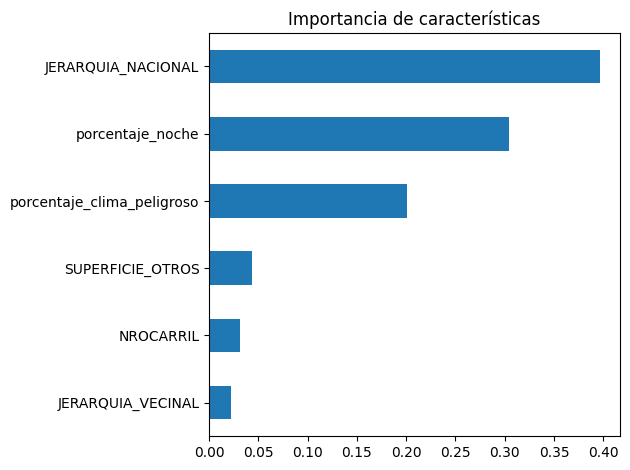

In [823]:
importances.head(10).plot(kind='barh', title='Importancia de características')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [824]:
df_encoded["Probabilidad_Predicha"] = rf.predict(X)

In [825]:
df_encoded["Riesgo"] = pd.cut(
    df_encoded["Probabilidad_Predicha"],
    bins=[-1, 50, 100, 200, 1000],
    labels=["Bajo", "Medio", "Alto", "Crítico"]
)

df_resultado = pd.DataFrame({
    "CODRUTA": codrutas,
    "Probabilidad_Predicha": df_encoded["Probabilidad_Predicha"],
    "Riesgo": df_encoded["Riesgo"]
})

print(df_resultado)

     CODRUTA  Probabilidad_Predicha   Riesgo
0     AM-101             116.913188     Alto
1     AM-102             104.843518     Alto
2     AM-103             301.023061  Crítico
3     AM-109             106.971566     Alto
4     AM-637             106.670544     Alto
...      ...                    ...      ...
1867  TU-524             125.796395     Alto
1868  TU-548             125.796395     Alto
1869  UC-102             104.843518     Alto
1870  UC-103             135.656863     Alto
1871  UC-103             116.913188     Alto

[1872 rows x 3 columns]
